In this notebook we will explore the different methods for calculating the VaR for an equity portfolio, and briefly discuss the some pros and cons associated with each.

In [180]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt

In [181]:
# Select the portfolio and weights
tickers = ['AAPL', 'C', 'WMT', 'F']
weights = [0.25, 0.25, 0.25, 0.25]
portfolio_weights = np.array(weights)
data = yf.download(tickers, start='2018-01-01', end='2023-06-26')['Adj Close']

[*********************100%***********************]  4 of 4 completed


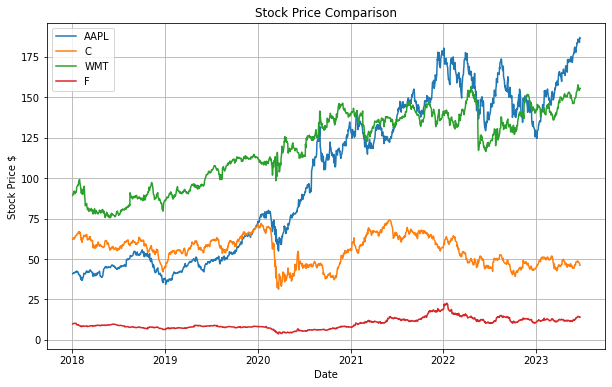

In [182]:
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Stock Price $')
plt.title('Stock Price Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Calculate Portfolio Returns

In [183]:
# We use log returns because they are symmetrical and additive over time
returns = data.pct_change().dropna()
log_returns = (np.log(data) - np.log(data.shift(1))).dropna()
returns.head(), log_returns.head()

(                AAPL         C         F       WMT
 Date                                              
 2018-01-03 -0.000174  0.003093  0.007899  0.008723
 2018-01-04  0.004645  0.012334  0.017241  0.000905
 2018-01-05  0.011385 -0.001324  0.016949  0.005927
 2018-01-08 -0.003714 -0.011670 -0.003788  0.014781
 2018-01-09 -0.000115  0.010466 -0.005323 -0.012007,
                 AAPL         C         F       WMT
 Date                                              
 2018-01-03 -0.000174  0.003088  0.007868  0.008685
 2018-01-04  0.004634  0.012259  0.017095  0.000905
 2018-01-05  0.011321 -0.001325  0.016807  0.005909
 2018-01-08 -0.003721 -0.011738 -0.003795  0.014673
 2018-01-09 -0.000115  0.010411 -0.005337 -0.012079)

In [184]:
#Number of days in dataset
n = log_returns.count()[0]
n

1377

In [185]:
# Calculate portfolio returns
portfolio_returns = np.dot(log_returns, portfolio_weights)

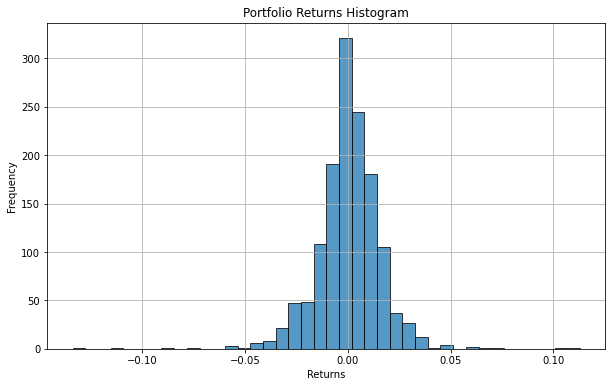

In [186]:
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=40, edgecolor='black', alpha=0.75)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Portfolio Returns Histogram')
plt.grid(True)
plt.show()

## Historical Method

In [187]:
# Define confidence level (i.e., 95%)
confidence_level = 0.05
sorted_returns = np.sort(portfolio_returns)

# Calculate VaR based on historical sorted returns
var = np.percentile(sorted_returns, confidence_level * 100)

print(f"Portfolio VaR at {confidence_level * 100}% confidence level: {abs(var):.2%}")

Portfolio VaR at 5.0% confidence level: 2.52%


In [188]:
print(f"At a 5% confidence level, under normal market conditions, based on historical data, there is a 95% chance \n that the portfolio's loss will be less than or equal to {abs(var):.2%}. Time frame is for a signle trading day")

At a 5% confidence level, under normal market conditions, based on historical data, there is a 95% chance 
 that the portfolio's loss will be less than or equal to 2.52%. Time frame is for a signle trading day


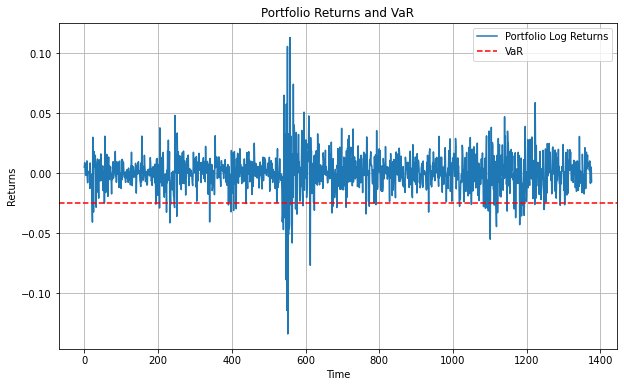

In [189]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label='Portfolio Log Returns')
plt.axhline(var, color='red', linestyle='--', label='VaR')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Portfolio Returns and VaR')
plt.legend()
plt.grid(True)
plt.show()

The historical method of calculating VaR proceeds with the assumption that past events and their associated risks will recur in the future, this calculation method requires ranking portfolio returns to fulfill assumptions. This method however does not consider events "unseen" in the historical data.

## Variance-Covariance Method

In [190]:
# Portfolio variance-covariance matrix
cov_matrix = np.cov(log_returns.T)
# Portfolio standard deviation
portfolio_std_dev = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
cov_matrix, portfolio_std_dev

(array([[4.23023609e-04, 2.34759803e-04, 2.10633490e-04, 1.11679166e-04],
        [2.34759803e-04, 5.76223187e-04, 3.71087489e-04, 8.29015724e-05],
        [2.10633490e-04, 3.71087489e-04, 6.83924731e-04, 7.26500608e-05],
        [1.11679166e-04, 8.29015724e-05, 7.26500608e-05, 2.07390124e-04]]),
 0.01592557851242961)

In [191]:
# Calculate z-score corresponding to the confidence level
z_score = norm.ppf(confidence_level)

# Calculate VaR using the variance-covariance method
var = norm.ppf(confidence_level, portfolio_returns.mean(), portfolio_std_dev)
print(f"Portfolio VaR (Variance-covariance) at {confidence_level * 100}% confidence level: {abs(var):.2%}")

Portfolio VaR (Variance-covariance) at 5.0% confidence level: 2.58%


In [192]:
print(f"Portfolio VaR for one year at {confidence_level * 100}% confidence level: {abs(var*np.sqrt(252)):.2%}")

Portfolio VaR for one year at 5.0% confidence level: 40.97%


In [193]:
var_lower = portfolio_returns.mean() + z_score * portfolio_std_dev
var_upper = portfolio_returns.mean() - z_score * portfolio_std_dev

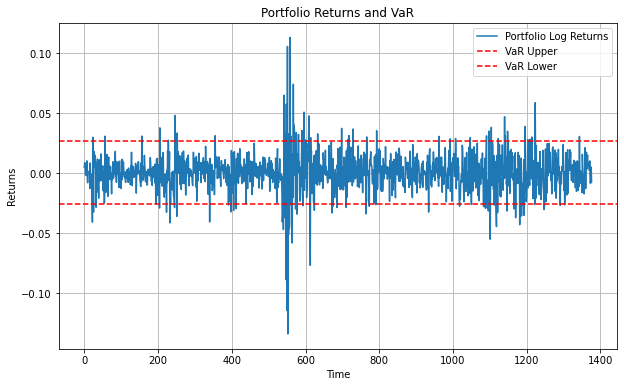

In [194]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label='Portfolio Log Returns')
plt.axhline(var_upper, color='red', linestyle='--', label='VaR Upper')
plt.axhline(var_lower, color='red', linestyle='--', label='VaR Lower')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Portfolio Returns and VaR')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
print(f"On a single day time horizon, with a 5% confidence interval, we are 95% confident that the portfolio return \n will be between {var_lower:.2%} , {var_upper:.2%}")

On a single day time horizon, with a 5% confidence interval, we are 95% confident that the portfolio return 
 will be between -2.58% , 2.66%


## Monte Carlo Method

In [196]:
#Number of simulations
mc_sims = 10000
t = 252 # Timeframe in days

initial_portfolio = 100000

In [197]:
#Empty array's to store simulation results 
meanM = np.full(shape=(t, len(portfolio_weights)), fill_value=log_returns.mean())
meanM = meanM.T
portfolio_sims = np.full(shape=(t,mc_sims), fill_value=0.0)

In [198]:
for m in range(0, mc_sims):
    Z = np.random.normal(size=(t,len(portfolio_weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(portfolio_weights, daily_returns.T) + 1)*initial_portfolio

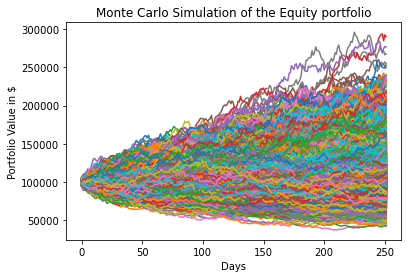

In [199]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value in $')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of the Equity portfolio')
plt.show()

In [200]:
def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected PD")
        
        
def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected PD")

In [201]:
port_results = pd.Series(portfolio_sims[-1, :])
mcvar = initial_portfolio - mcVaR(port_results, alpha=5)
mcCvar = initial_portfolio - mcCVaR(port_results, alpha=5)

In [202]:
print('Var ${}'.format(round(mcvar,2)))
print('CVar ${}'.format(round(mcCvar,2)))

Var $29100.29
CVar $36242.39


In [203]:
print(f"Portfolio VaR (Monte Carlo) at the end of 1 trading year time horizon at {confidence_level * 100}% confidence level: {(round(mcvar,2)/initial_portfolio):.2%}")

Portfolio VaR (Monte Carlo) at the end of 1 trading year time horizon at 5.0% confidence level: 29.10%


The Conditional Value-at-Risk (CVaR) represents the expected shortfall, VaR provides a threshold or quantile level at which the worst outcomes can be defined, while ES goes further by considering the average or expected loss beyond that threshold.

Monte Carlo Simulation for the purpose of VaR modelling, is more challenging to calculate compared to other methods, however, the simulation of a large number of random walks adds an element of unpredictability and helps to provide better insights into the likelihood and distribution of potential outcomes. 